# Gesture Recognition Case Study

 * **Dharmendra Kumar – Group Facilitator**
 * **Ashwin Kumar h**


In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

<h3>Problem Statement</h3>

In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.
Problem Statement

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

<table>
<thead>
<tr>
<th>Gesture</th>
<th>Corresponding Action</th>
</tr>
</thead>
<tbody>
<tr>
<td>Thumbs Up</td>
<td>Increase the volume.</td>
</tr>
<tr>
<td>Thumbs Down</td>
<td>Decrease the volume.</td>
</tr>
<tr>
<td>Left Swipe</td>
<td>'Jump' backwards 10 seconds.</td>
</tr>
<tr>
<td>Right Swipe</td>
<td>'Jump' forward 10 seconds.</td>
</tr>
<tr>
<td>Stop</td>
<td>Pause the movie.</td>
</tr>
</tbody>
</table>

The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos.

<b>Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.</b>

Your task is to train a model on the 'train' folder which performs well on the 'val' folder as well (as usually done in ML projects). We have withheld the test folder for evaluation purposes - your final model's performance will be tested on the 'test' set.


In [1]:
## Checking the GPU configuration

!nvidia-smi

Mon Feb  6 05:31:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
# Importing the necessary libraries
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import datetime
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [29]:
#We set the random seed so that the results don't vary drastically.
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [30]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2023-02-06 06:00:43.085350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 06:00:43.085922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 06:00:43.086321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 06:00:43.086793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-06 06:00:43.087139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.


In [31]:
#loading .csv file 
train_doc = np.random.permutation(open('../input/gesturerecognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../input/gesturerecognition/Project_data/val.csv').readlines())
batch_size = 64

In [32]:
# function to plot the training/validation accuracies/losses.
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Generator

This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [33]:
def cropResize(image, y, z):
    h, w = image.shape
    
    # if smaller image crop at center for 120x120
    if w == 160:
        image = image[:120, 20:140]

    # resize every image
    return resize(image, (y,z))

In [34]:
#normalizing the images
def normalizeImage(image):
    # applying normalization
    return image/255.0

In [36]:
#preprocessImage function is defined for cropping
def preprocessImage(image, y, z):
    return normalizeImage(cropResize(image, y, z))

In [38]:
def make3dFilter(x):
    return tuple([x]*3)

def make2dFilter(x):
    return tuple([x]*2)

In [48]:
  #normalizing the images
def getBatchData(source_path, t, batch, batch_size, img_tensor):
    [x,y,z] = [len(img_tensor[0]),img_tensor[1], img_tensor[2]]
    img_idx = img_tensor[0]
    batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    for folder in range(batch_size): # iterate over the batch_size
        imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
        for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
            image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes

            # separate preprocessImage function is defined for cropping, resizing and normalizing images
            batch_data[folder,idx,:,:,0] = preprocessImage(image[:, :, 0], y, z)
            batch_data[folder,idx,:,:,1] = preprocessImage(image[:, :, 1], y, z)
            batch_data[folder,idx,:,:,2] = preprocessImage(image[:, :, 2], y, z)

        batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
    return batch_data, batch_labels

In [40]:
# MOST IMPORTANT PART HERE - The generator function
def generator(source_path, folder_list, batch_size, img_tensor):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)
        
        # write the code for the remaining data points which are left after full batches
        # checking if any remaining batches are there or not
        if len(folder_list)%batch_size != 0:
            # updated the batch size and yield
            batch_size = len(folder_list)%batch_size
            yield getBatchData(source_path, t, batch, batch_size, img_tensor)

<b>Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.</b>

In [41]:
curr_dt_time = datetime.datetime.now()
train_path = '../input/gesturerecognition/Project_data/train'
val_path = '../input/gesturerecognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [70]:
def getImgTensor(n_frames):
    img_idx = np.round(np.linspace(0, 29, n_frames)).astype(int)
    return [img_idx, 100, 100, 3]

# define image tensor size
img_tensor = getImgTensor(20)
print ('# img_tensor =', img_tensor)

# img_tensor = [array([ 0,  2,  3,  5,  6,  8,  9, 11, 12, 14, 15, 17, 18, 20, 21, 23, 24,
       26, 27, 29]), 100, 100, 3]


<h3>Generator Validation</h3>
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with img_idx, y,z and normalization such that you get high accuracy.

In [49]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, img_tensor)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, img_tensor)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  ../input/gesturerecognition/Project_data/train ; batch size = 64
(64, 20, 100, 100, 3)
Source path =  ../input/gesturerecognition/Project_data/val ; batch size = 64
(64, 20, 100, 100, 3)


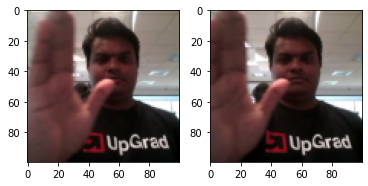

In [50]:
# plot generated sample images
fig, ax = plt.subplots(1,2)
ax[0].imshow(sample_val_batch_data[0,1,:,:,:])
ax[1].imshow(sample_val_batch_data[0,3,:,:,:])
plt.show()

In [51]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))


# Model Building

Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.


In [52]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from tensorflow import keras
from keras.layers import Dropout
import tensorflow as tf 

<h3>Base Model</h3>

In [54]:
#write your model here
def defineModel(img_tensor):
    inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

    model = Sequential([
        Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
        MaxPooling3D(make3dFilter(2), padding='same'),
        BatchNormalization(),

        Conv3D(32, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Conv3D(64, make3dFilter(3), activation='relu'),
        MaxPooling3D(pool_size=(1,2,2), padding='same'),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),

        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = defineModel(img_tensor)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 16, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 8, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 48, 48, 16)     64        
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 6, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 6, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 6, 23, 23, 32)     128       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 4, 21, 21, 64)    

In [55]:
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.


In [56]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

<h3>Model Callbacks Setup</h3>

In [57]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
callbacks_list = [checkpoint, LR, earlystop]

<h3>Model 1 - Frames-16, Epoc-20</h3>


In [58]:
n_frames = 16
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model1 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d1")
model1.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model1.summary())

model1_history = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 12, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 6, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 6, 48, 48, 16)     64        
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 4, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 4, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 23, 23, 32)     128       
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 2, 21, 21, 64)     553

2023-02-06 06:04:36.309576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-02-06 06:04:38.691466: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


11/11 [==============================] - 147s 14s/step - loss: 1.5233 - categorical_accuracy: 0.4781 - val_loss: 2.4251 - val_categorical_accuracy: 0.2700

Epoch 00001: val_loss improved from inf to 2.42505, saving model to model_init_2023-02-0606_01_12.245131/model-00001-1.52331-0.47813-2.42505-0.27000.h5
Epoch 2/20
11/11 [==============================] - 48s 5s/step - loss: 1.1057 - categorical_accuracy: 0.5731 - val_loss: 5.9321 - val_categorical_accuracy: 0.1875

Epoch 00002: val_loss did not improve from 2.42505
Epoch 3/20
11/11 [==============================] - 42s 4s/step - loss: 1.1480 - categorical_accuracy: 0.5573 - val_loss: 3.5216 - val_categorical_accuracy: 0.2679

Epoch 00003: val_loss did not improve from 2.42505
Epoch 4/20
11/11 [==============================] - 34s 3s/step - loss: 0.9567 - categorical_accuracy: 0.6352 - val_loss: 1.8771 - val_categorical_accuracy: 0.1875

Epoch 00004: val_loss improved from 2.42505 to 1.87712, saving model to model_init_2023-02-0606

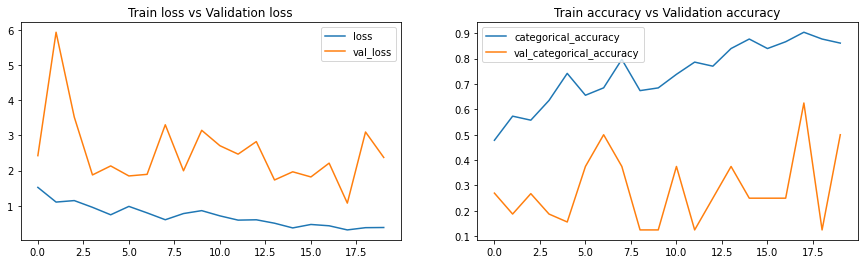

Max. Training Accuracy 0.903743326663971
Max. Validaiton Accuracy 0.625


In [59]:
plotModelHistory(model1_history)

<h3>Model 2: Frames-20, Epocs-25</h3>

In [60]:
n_frames = 20
num_epochs = 25
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 16, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 8, 48, 48, 16)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 8, 48, 48, 16)     64        
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 6, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 6, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 6, 23, 23, 32)     128       
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 4, 21, 21, 64)     553

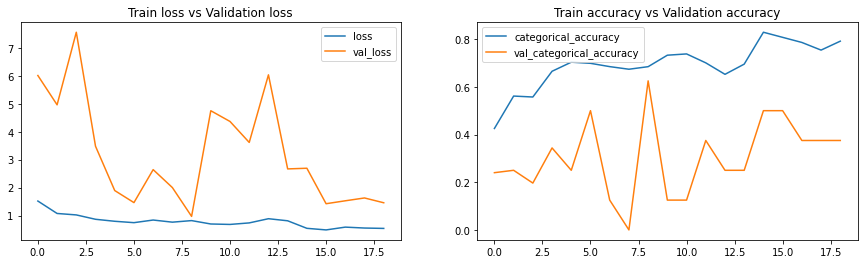

Max. Training Accuracy 0.8288770318031311
Max. Validaiton Accuracy 0.625


In [61]:
plotModelHistory(model2_history)

<h3>Model 3: Frames-25, Epocs-20, Reduced parameters</h3>

In [62]:
n_frames = 25
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model2 = Sequential([
    Conv3D(16, make3dFilter(5), activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), activation='relu'),
    MaxPooling3D(pool_size=(1,2,2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d2")
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model2.summary())

model2_history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 21, 96, 96, 16)    6016      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 11, 48, 48, 16)    0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 11, 48, 48, 16)    64        
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 9, 46, 46, 32)     13856     
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 9, 23, 23, 32)     0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 9, 23, 23, 32)     128       
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 7, 21, 21, 64)     553

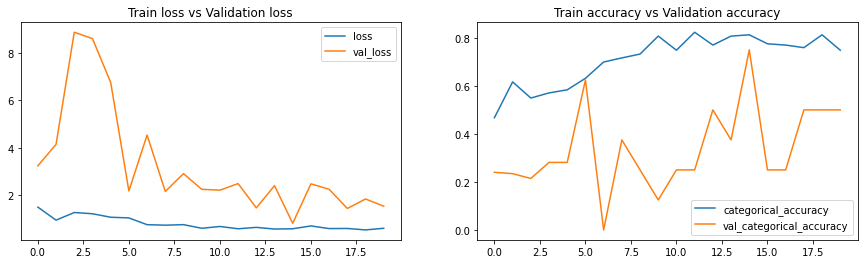

Max. Training Accuracy 0.8235294222831726
Max. Validaiton Accuracy 0.75


In [63]:
plotModelHistory(model2_history)

<h3>Model 4: Frames-20, Same pooling in Conv3D layer</h3>

In [64]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model4 = Sequential([
    Conv3D(16, make3dFilter(3), padding='same', activation='relu', input_shape=inputShape),
    MaxPooling3D(make3dFilter(2), padding='same'),
    BatchNormalization(),

    Conv3D(32, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(64, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Conv3D(128, make3dFilter(3), padding='same', activation='relu'),
    MaxPooling3D(pool_size=(2), padding='same'),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(5, activation='softmax')
], name="conv_3d4")
model4.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model4.summary())

model4_history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 20, 100, 100, 16)  1312      
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 10, 50, 50, 16)    64        
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 10, 50, 50, 32)    13856     
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 5, 25, 25, 32)     128       
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 5, 25, 25, 64)     553

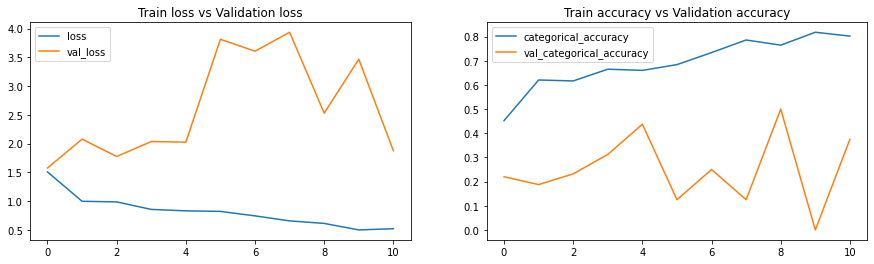

Max. Training Accuracy 0.8181818127632141
Max. Validaiton Accuracy 0.5


In [67]:
plotModelHistory(model4_history)

<h3>Model 5: Frames:20, Epocs-20, BS-64, reduced kernel to (2,2,2), switching BatchNormalization before MaxPooling</h3>

In [68]:
n_frames = 20
num_epochs = 20
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model5 = Sequential([
    Conv3D(16, make3dFilter(2), padding='same', activation='relu', input_shape=inputShape),
    BatchNormalization(),
    MaxPooling3D(make3dFilter(2)),

    Conv3D(32, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(64, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Conv3D(128, make3dFilter(2), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2)),

    Flatten(),
    Dense(256, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.3),

    Dense(128, activation='relu'),
    # BatchNormalization(),
    # Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_3d5")
model5.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model5.summary())

model5_history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_3d5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_27 (Conv3D)           (None, 20, 100, 100, 16)  400       
_________________________________________________________________
batch_normalization_39 (Batc (None, 20, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_27 (MaxPooling (None, 10, 50, 50, 16)    0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 10, 50, 50, 32)    4128      
_________________________________________________________________
batch_normalization_40 (Batc (None, 10, 50, 50, 32)    128       
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 5, 25, 25, 32)     0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 5, 25, 25, 64)     164

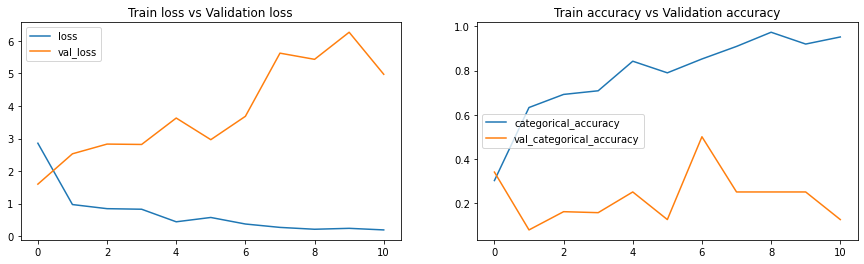

Max. Training Accuracy 0.9732620120048523
Max. Validaiton Accuracy 0.5


In [71]:
plotModelHistory(model5_history)

<h3>Model 6: Switching Model architecture to Conv2D+LSTM</h3>

In [72]:
n_frames = 20
num_epochs = 30
batch_size = 32

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model6 = Sequential([
    TimeDistributed(Conv2D(16, make2dFilter(3), padding='same', activation='relu'), input_shape=inputShape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(32, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(64, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(128, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Conv2D(256, make2dFilter(3), padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(make2dFilter(2))),

    TimeDistributed(Flatten()),
    LSTM(256),
    Dropout(0.2),

    Dense(256, activation='relu'),
    Dropout(0.2),

    Dense(5, activation='softmax')
], name="conv_2d_lstm")
model6.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model6.summary())

model6_history = model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "conv_2d_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 25, 25, 64)   

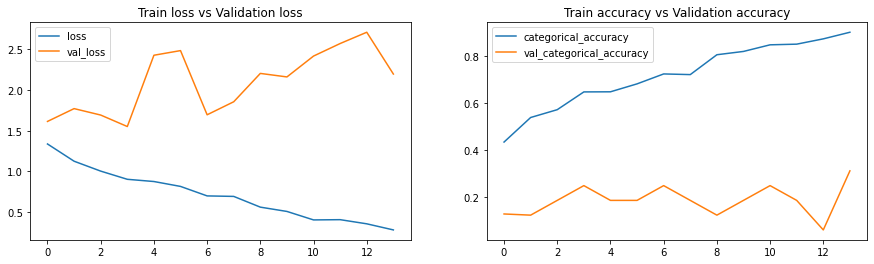

Max. Training Accuracy 0.8991596698760986
Max. Validaiton Accuracy 0.3125


In [74]:
plotModelHistory(model6_history)

<h3>Model 7: Transfer Learning (MobileNet) with LSTM</h3>

In [73]:
from tensorflow.keras.applications import mobilenet

In [75]:
mobilenet = mobilenet.MobileNet(weights='imagenet', include_top=False)

n_frames = 20
num_epochs = 30
batch_size = 64

img_tensor = getImgTensor(n_frames)
train_generator = generator(train_path, train_doc, batch_size, img_tensor)
val_generator = generator(val_path, val_doc, batch_size, img_tensor)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
inputShape = (len(img_tensor[0]), img_tensor[1], img_tensor[2], img_tensor[3])

model7 = Sequential([
    TimeDistributed(mobilenet, input_shape=inputShape)
], name="mobilenet_lstm")

for layer in model7.layers:
    layer.trainable = False

model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D(make2dFilter(2))))
model7.add(TimeDistributed(Flatten()))

model7.add(LSTM(256))
model7.add(Dropout(0.2))

model7.add(Dense(256,activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(5, activation='softmax'))

model7.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model7.summary())

model7_history = model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
            callbacks=callbacks_list, validation_data=val_generator, 
            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "mobilenet_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_17 (TimeDis (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_18 (TimeDis (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 20, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               1311744   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)            

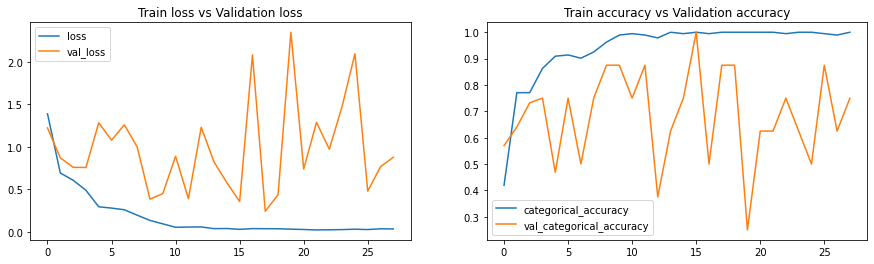

Max. Training Accuracy 1.0
Max. Validaiton Accuracy 1.0


In [76]:
plotModelHistory(model7_history)

<h2>After doing all the experiments, we finalized Model 7 - Transfer Learning (MobileNet) with LSTM, which giving best results.</h2>

**Reason:**

**- (Training Accuracy : 100%, Validation Accuracy : 100%)**

**- Number of Parameters**

    Total params: 4,611,781
    Trainable params: 1,380,869
    Non-trainable params: 3,230,912

**- Learning rate gradually decreacing after 8 Epoch**

**The best weights of CNN-LSTM: model-00020-0.19649-0.93514-0.45695-0.85000.h5 (29 MB). we considered this weight for model testing, Let's have look at the performance below**

In [ ]:
# Downloading .h5 file of best result for submission.
import time
from keras.models import load_model
model = load_model('model_init_2023-02-0606_01_12.245131/model-00018-0.03587-1.00000-0.24042-0.87500.h5')